# Reinforcement Learning Project: Car Racing with Deep Q-Network (DQN)

## Project Overview
This notebook implements a DQN agent to solve the Car Racing environment from Gymnasium. The project covers:
- Environment setup and exploration
- DQN algorithm implementation
- Training with experience replay and target networks
- Hyperparameter tuning
- Performance evaluation and visualization

**Environment**: Car Racing-v2 (Gymnasium/Box2D)

**Algorithm**: Deep Q-Network (DQN) with:
- Experience Replay Buffer
- Target Network
- Frame Stacking
- Epsilon-Greedy Exploration

## 1. Installations

In [2]:
!pip install matplotlib opencv-python tqdm tensorboard
!pip install "numpy<2.0"

  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-f

In [3]:
!pip uninstall -y torch torchvision
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121


Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp311-cp311-linux_x86_64.whl (780.5 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp311-cp311-linux_x86_64.whl (7.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchvision] [torchvision]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.5.1+cu121 which is incompatible.


In [4]:
!python -m pip install -U pip setuptools wheel
!python -m pip uninstall -y box2d-py Box2D
!python -m pip install ufal.pybox2d==2.3.10.4
!python -m pip install --no-deps gymnasium pygame

In [5]:
# Import libraries
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os
from datetime import datetime

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device configuration
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


## 2. Environment exploration

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3146: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/l


=== Environment Information ===
Observation space: Box(0, 255, (96, 96, 3), uint8)
Action space: Box([-1.  0.  0.], 1.0, (3,), float32)
Action space shape: (3,)

Action Description:
  - Action[0]: Steering (-1.0 left, +1.0 right)
  - Action[1]: Gas (0.0 to 1.0)
  - Action[2]: Brake (0.0 to 1.0)

State shape: (96, 96, 3)


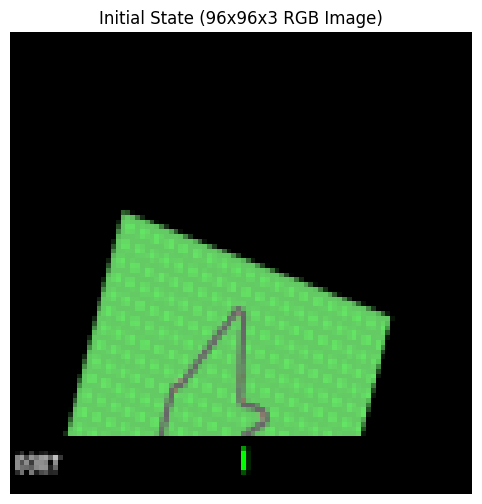

In [6]:
# Create and explore the environment
env = gym.make('CarRacing-v2', render_mode='rgb_array')

print("\n=== Environment Information ===")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Action space shape: {env.action_space.shape}")
print(f"\nAction Description:")
print("  - Action[0]: Steering (-1.0 left, +1.0 right)")
print("  - Action[1]: Gas (0.0 to 1.0)")
print("  - Action[2]: Brake (0.0 to 1.0)")

# Reset and visualize initial state
state, info = env.reset(seed=SEED)
print(f"\nState shape: {state.shape}")

plt.figure(figsize=(8, 6))
plt.imshow(state)
plt.title("Initial State (96x96x3 RGB Image)")
plt.axis('off')
plt.show()

env.close()

## 3. Preprocessing and Framestacking

We'll preprocess the frames to:
- Convert to grayscale
- Resize to 84x84
- Stack 4 consecutive frames to capture motion

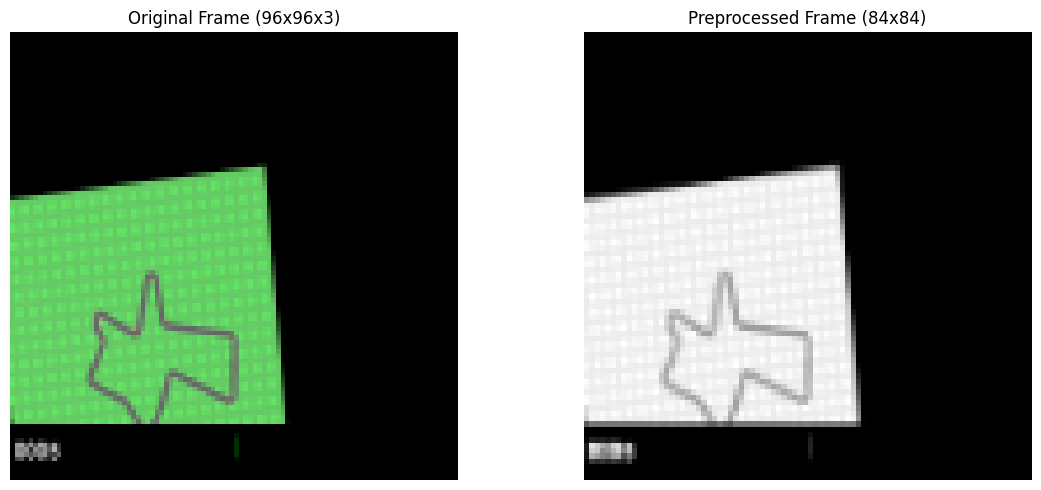

In [7]:
class FrameStack:
    """Stack frames to capture temporal information"""
    def __init__(self, num_stack=4):
        self.num_stack = num_stack
        self.frames = deque(maxlen=num_stack)
    
    def reset(self):
        self.frames.clear()
    
    def add_frame(self, frame):
        self.frames.append(frame)
    
    def get_state(self):
        # Ensure we have enough frames
        while len(self.frames) < self.num_stack:
            self.frames.append(self.frames[-1] if self.frames else np.zeros((84, 84)))
        return np.stack(self.frames, axis=0)


def preprocess_frame(frame):
    """Preprocess a single frame"""
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # Resize to 84x84
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
    # Normalize to [0, 1]
    normalized = resized / 255.0
    return normalized.astype(np.float32)


# Test preprocessing
env = gym.make('CarRacing-v2', render_mode='rgb_array')
state, _ = env.reset()
processed = preprocess_frame(state)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(state)
axes[0].set_title("Original Frame (96x96x3)")
axes[0].axis('off')

axes[1].imshow(processed, cmap='gray')
axes[1].set_title("Preprocessed Frame (84x84)")
axes[1].axis('off')
plt.tight_layout()
plt.show()

env.close()

## 4. Discretize Action Space

Car Racing has a continuous action space. We'll discretize it into 5 actions for DQN.

In [ ]:
ACTIONS = [
    np.array([0.0, 0.0, 0.0]),     # 0: Do nothing
    np.array([-1.0, 0.0, 0.0]),    # 1: Steer left
    np.array([1.0, 0.0, 0.0]),     # 2: Steer right
    np.array([0.0, 1.0, 0.0]),     # 3: Gas
    np.array([0.0, 0.0, 0.8]),     # 4: Brake
]

ACTION_NAMES = ["Do Nothing", "Left", "Right", "Gas", "Brake"]
NUM_ACTIONS = len(ACTIONS)

print("Discrete Action Space:")
for i, (action, name) in enumerate(zip(ACTIONS, ACTION_NAMES)):
    print(f"  {i}: {name:12s} -> {action}")

Discrete Action Space:
  0: Do Nothing   -> [0. 0. 0.]
  1: Left         -> [-1.  0.  0.]
  2: Right        -> [1. 0. 0.]
  3: Gas          -> [0. 1. 0.]
  4: Brake        -> [0.  0.  0.8]


## 5. Experience Replay Buffer

In [9]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayBuffer:
    """Experience replay buffer for DQN"""
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, *args):
        """Save a transition"""
        self.buffer.append(Transition(*args))
    
    def sample(self, batch_size):
        """Sample a batch of transitions"""
        transitions = random.sample(self.buffer, batch_size)
        batch = Transition(*zip(*transitions))
        
        states = torch.FloatTensor(np.array(batch.state)).to(device)
        actions = torch.LongTensor(batch.action).to(device)
        next_states = torch.FloatTensor(np.array(batch.next_state)).to(device)
        rewards = torch.FloatTensor(batch.reward).to(device)
        dones = torch.FloatTensor(batch.done).to(device)
        
        return states, actions, next_states, rewards, dones
    
    def __len__(self):
        return len(self.buffer)

print("Replay Buffer implemented successfully!")

Replay Buffer implemented successfully!


## 6. The DQN Architecture

In [10]:
class DQN(nn.Module):
    """Deep Q-Network using CNN for image processing"""
    def __init__(self, num_actions, num_frames=4):
        super(DQN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(num_frames, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # Calculate the size of the flattened features
        self.feature_size = self._get_conv_output((num_frames, 84, 84))
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_size, 512)
        self.fc2 = nn.Linear(512, num_actions)
    
    def _get_conv_output(self, shape):
        """Calculate the output size of conv layers"""
        with torch.no_grad():
            input = torch.zeros(1, *shape)
            output = self.conv1(input)
            output = self.conv2(output)
            output = self.conv3(output)
            return int(np.prod(output.size()))
    
    def forward(self, x):
        """Forward pass"""
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Test the network
test_net = DQN(NUM_ACTIONS).to(device)
test_input = torch.randn(1, 4, 84, 84).to(device)
test_output = test_net(test_input)
print(f"Network output shape: {test_output.shape}")
print(f"Number of parameters: {sum(p.numel() for p in test_net.parameters()):,}")

Network output shape: torch.Size([1, 5])
Number of parameters: 1,686,693


## 7. DQN Agent

In [11]:
class DQNAgent:
    """DQN Agent with target network and experience replay"""
    def __init__(self, num_actions, hyperparameters):
        self.num_actions = num_actions
        self.hp = hyperparameters
        
        # Networks
        self.policy_net = DQN(num_actions).to(device)
        self.target_net = DQN(num_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.hp['learning_rate'])
        
        # Replay buffer
        self.memory = ReplayBuffer(self.hp['buffer_size'])
        
        # Training stats
        self.steps = 0
        self.epsilon = self.hp['epsilon_start']
    
    def select_action(self, state, training=True):
        """Select action using epsilon-greedy policy"""
        if training and random.random() < self.epsilon:
            return random.randrange(self.num_actions)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.policy_net(state_tensor)
                return q_values.argmax().item()
    
    def update_epsilon(self):
        """Decay epsilon"""
        self.epsilon = max(self.hp['epsilon_end'], 
                          self.epsilon * self.hp['epsilon_decay'])
    
    def update_target_network(self):
        """Copy policy network weights to target network"""
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def train_step(self):
        """Perform one training step"""
        if len(self.memory) < self.hp['batch_size']:
            return None
        
        # Sample batch
        states, actions, next_states, rewards, dones = self.memory.sample(self.hp['batch_size'])
        
        # Compute Q(s, a)
        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        # Compute target Q values
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.hp['gamma'] * next_q_values
        
        # Compute loss
        loss = F.smooth_l1_loss(q_values.squeeze(), target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10)
        self.optimizer.step()
        
        return loss.item()
    
    def save(self, filepath):
        """Save model checkpoint"""
        torch.save({
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'steps': self.steps
        }, filepath)
    
    def load(self, filepath):
        """Load model checkpoint"""
        checkpoint = torch.load(filepath, map_location=device)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']
        self.steps = checkpoint['steps']

print("DQN Agent implemented successfully!")

DQN Agent implemented successfully!


## 8. Hyperparameters Configuration

In [12]:
HYPERPARAMETERS = {
    # Network
    'learning_rate': 1e-4,
    
    # Replay buffer
    'buffer_size': 200_000,
    'batch_size': 64,
    
    # Training
    'gamma': 0.99,              # Discount factor
    'target_update': 5000,      # Update target network every N steps
    
    # Exploration
    'epsilon_start': 1.0,
    'epsilon_end': 0.05,
    'epsilon_decay': 0.992,
    
    # Episodes
    'num_episodes': 1000,
    'max_steps': 1000,
}
print("Hyperparameters:")
for key, value in HYPERPARAMETERS.items():
    print(f"  {key:20s}: {value}")

Hyperparameters:
  learning_rate       : 0.0001
  buffer_size         : 200000
  batch_size          : 64
  gamma               : 0.99
  target_update       : 5000
  epsilon_start       : 1.0
  epsilon_end         : 0.05
  epsilon_decay       : 0.992
  num_episodes        : 1000
  max_steps           : 1000


## Training Loop

In [13]:
def train_dqn(agent, env, hyperparameters, save_dir='models'):
    """Train the DQN agent"""
    os.makedirs(save_dir, exist_ok=True)
    
    # Training statistics
    episode_rewards = []
    episode_lengths = []
    losses = []
    epsilons = []
    
    best_reward = -float('inf')
    
    for episode in tqdm(range(hyperparameters['num_episodes']), desc="Training"):
        # Reset environment
        state, _ = env.reset()
        frame_stack = FrameStack(num_stack=4)
        
        # Initial frame stacking
        processed_frame = preprocess_frame(state)
        for _ in range(4):
            frame_stack.add_frame(processed_frame)
        current_state = frame_stack.get_state()
        
        episode_reward = 0
        episode_loss = []
        
        for step in range(hyperparameters['max_steps']):
            # Select and perform action
            action_idx = agent.select_action(current_state)
            action = ACTIONS[action_idx]
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Preprocess next state
            processed_frame = preprocess_frame(next_state)
            frame_stack.add_frame(processed_frame)
            next_state_stacked = frame_stack.get_state()
            
            # Store transition
            agent.memory.push(current_state, action_idx, next_state_stacked, reward, float(done))
            
            current_state = next_state_stacked
            episode_reward += reward
            agent.steps += 1
            
            # Train
            loss = agent.train_step()
            if loss is not None:
                episode_loss.append(loss)
            
            # Update target network
            if agent.steps % hyperparameters['target_update'] == 0:
                agent.update_target_network()
            
            if done:
                break
        
        # Update epsilon
        agent.update_epsilon()
        
        # Record statistics
        episode_rewards.append(episode_reward)
        episode_lengths.append(step + 1)
        epsilons.append(agent.epsilon)
        if episode_loss:
            losses.append(np.mean(episode_loss))
        
        # Save best model
        if episode_reward > best_reward:
            best_reward = episode_reward
            agent.save(os.path.join(save_dir, 'best_model.pth'))
        
        # Periodic logging
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_length = np.mean(episode_lengths[-10:])
            avg_loss = np.mean(losses[-10:]) if losses else 0
            print(f"\nEpisode {episode+1}/{hyperparameters['num_episodes']}")
            print(f"  Avg Reward (last 10): {avg_reward:.2f}")
            print(f"  Avg Length (last 10): {avg_length:.1f}")
            print(f"  Avg Loss (last 10): {avg_loss:.4f}")
            print(f"  Epsilon: {agent.epsilon:.3f}")
            print(f"  Best Reward: {best_reward:.2f}")
        
        # Save checkpoint
        if (episode + 1) % 50 == 0:
            agent.save(os.path.join(save_dir, f'checkpoint_ep{episode+1}.pth'))
    
    # Save final model
    agent.save(os.path.join(save_dir, 'final_model.pth'))
    
    return {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'losses': losses,
        'epsilons': epsilons
    }

print("Training function ready!")

Training function ready!


## 10. Start the training

In [14]:
# Create environment
env = gym.make('CarRacing-v2', render_mode='rgb_array')

# Create agent
agent = DQNAgent(NUM_ACTIONS, HYPERPARAMETERS)

# Train agent
training_stats = train_dqn(agent, env, HYPERPARAMETERS)

env.close()
print("\nTraining completed!")

Training:   1%|          | 10/1000 [03:06<5:09:11, 18.74s/it]


Episode 10/1000
  Avg Reward (last 10): -54.47
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.0336
  Epsilon: 0.923
  Best Reward: -47.76


Training:   2%|▏         | 20/1000 [06:18<5:13:55, 19.22s/it]


Episode 20/1000
  Avg Reward (last 10): -53.27
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.0334
  Epsilon: 0.852
  Best Reward: -44.66


Training:   3%|▎         | 30/1000 [09:30<5:11:40, 19.28s/it]


Episode 30/1000
  Avg Reward (last 10): -48.41
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.0327
  Epsilon: 0.786
  Best Reward: -36.57


Training:   4%|▍         | 40/1000 [12:44<5:17:42, 19.86s/it]


Episode 40/1000
  Avg Reward (last 10): -39.91
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.0367
  Epsilon: 0.725
  Best Reward: -32.08


Training:   5%|▌         | 50/1000 [16:01<5:06:06, 19.33s/it]


Episode 50/1000
  Avg Reward (last 10): -25.30
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.0400
  Epsilon: 0.669
  Best Reward: -2.10


Training:   6%|▌         | 60/1000 [19:14<5:03:04, 19.35s/it]


Episode 60/1000
  Avg Reward (last 10): -28.19
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.0433
  Epsilon: 0.618
  Best Reward: 4.65


Training:   7%|▋         | 70/1000 [22:28<5:03:10, 19.56s/it]


Episode 70/1000
  Avg Reward (last 10): -28.17
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.0452
  Epsilon: 0.570
  Best Reward: 4.65


Training:   8%|▊         | 80/1000 [25:43<4:57:37, 19.41s/it]


Episode 80/1000
  Avg Reward (last 10): -17.06
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.0468
  Epsilon: 0.526
  Best Reward: 72.00


Training:   9%|▉         | 90/1000 [28:55<4:50:00, 19.12s/it]


Episode 90/1000
  Avg Reward (last 10): -21.54
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.0491
  Epsilon: 0.485
  Best Reward: 72.00


Training:  10%|█         | 100/1000 [32:09<4:52:23, 19.49s/it]


Episode 100/1000
  Avg Reward (last 10): -17.76
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.0501
  Epsilon: 0.448
  Best Reward: 72.00


Training:  11%|█         | 110/1000 [35:24<4:52:02, 19.69s/it]


Episode 110/1000
  Avg Reward (last 10): -27.92
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.0508
  Epsilon: 0.413
  Best Reward: 72.00


Training:  12%|█▏        | 120/1000 [38:38<4:46:07, 19.51s/it]


Episode 120/1000
  Avg Reward (last 10): -12.70
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.0522
  Epsilon: 0.381
  Best Reward: 72.00


Training:  13%|█▎        | 130/1000 [41:54<4:43:53, 19.58s/it]


Episode 130/1000
  Avg Reward (last 10): 6.29
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.0538
  Epsilon: 0.352
  Best Reward: 223.84


Training:  14%|█▍        | 140/1000 [45:11<4:41:14, 19.62s/it]


Episode 140/1000
  Avg Reward (last 10): -12.40
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.0558
  Epsilon: 0.325
  Best Reward: 223.84


Training:  15%|█▌        | 150/1000 [48:29<4:40:14, 19.78s/it]


Episode 150/1000
  Avg Reward (last 10): -21.36
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.0565
  Epsilon: 0.300
  Best Reward: 223.84


Training:  16%|█▌        | 160/1000 [51:46<4:36:00, 19.71s/it]


Episode 160/1000
  Avg Reward (last 10): -8.53
  Avg Length (last 10): 983.5
  Avg Loss (last 10): 0.0582
  Epsilon: 0.277
  Best Reward: 223.84


Training:  17%|█▋        | 170/1000 [54:41<3:53:36, 16.89s/it]


Episode 170/1000
  Avg Reward (last 10): -52.34
  Avg Length (last 10): 874.8
  Avg Loss (last 10): 0.0612
  Epsilon: 0.255
  Best Reward: 223.84


Training:  18%|█▊        | 180/1000 [56:59<3:22:08, 14.79s/it]


Episode 180/1000
  Avg Reward (last 10): -71.14
  Avg Length (last 10): 678.7
  Avg Loss (last 10): 0.0666
  Epsilon: 0.236
  Best Reward: 223.84


Training:  19%|█▉        | 190/1000 [59:15<3:30:52, 15.62s/it]


Episode 190/1000
  Avg Reward (last 10): -70.85
  Avg Length (last 10): 694.6
  Avg Loss (last 10): 0.0741
  Epsilon: 0.217
  Best Reward: 223.84


Training:  20%|██        | 200/1000 [1:02:06<4:19:30, 19.46s/it]


Episode 200/1000
  Avg Reward (last 10): 23.20
  Avg Length (last 10): 851.2
  Avg Loss (last 10): 0.0769
  Epsilon: 0.201
  Best Reward: 223.84


Training:  21%|██        | 210/1000 [1:05:24<4:18:55, 19.66s/it]


Episode 210/1000
  Avg Reward (last 10): 8.07
  Avg Length (last 10): 981.6
  Avg Loss (last 10): 0.0794
  Epsilon: 0.185
  Best Reward: 223.84


Training:  22%|██▏       | 220/1000 [1:08:22<3:42:44, 17.13s/it]


Episode 220/1000
  Avg Reward (last 10): -1.35
  Avg Length (last 10): 895.3
  Avg Loss (last 10): 0.0820
  Epsilon: 0.171
  Best Reward: 223.84


Training:  23%|██▎       | 230/1000 [1:11:10<4:02:33, 18.90s/it]


Episode 230/1000
  Avg Reward (last 10): 19.25
  Avg Length (last 10): 848.2
  Avg Loss (last 10): 0.0882
  Epsilon: 0.158
  Best Reward: 223.84


Training:  24%|██▍       | 240/1000 [1:14:12<3:47:46, 17.98s/it]


Episode 240/1000
  Avg Reward (last 10): 99.87
  Avg Length (last 10): 912.2
  Avg Loss (last 10): 0.0906
  Epsilon: 0.145
  Best Reward: 436.76


Training:  25%|██▌       | 250/1000 [1:17:36<4:17:16, 20.58s/it]


Episode 250/1000
  Avg Reward (last 10): 346.75
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.1001
  Epsilon: 0.134
  Best Reward: 630.50


Training:  26%|██▌       | 260/1000 [1:21:02<4:12:19, 20.46s/it]


Episode 260/1000
  Avg Reward (last 10): 425.13
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.1086
  Epsilon: 0.124
  Best Reward: 675.10


Training:  27%|██▋       | 270/1000 [1:24:27<4:08:47, 20.45s/it]


Episode 270/1000
  Avg Reward (last 10): 475.24
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.1149
  Epsilon: 0.114
  Best Reward: 690.87


Training:  28%|██▊       | 280/1000 [1:27:52<4:06:09, 20.51s/it]


Episode 280/1000
  Avg Reward (last 10): 692.18
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.1226
  Epsilon: 0.106
  Best Reward: 838.70


Training:  29%|██▉       | 290/1000 [1:31:18<4:02:30, 20.49s/it]


Episode 290/1000
  Avg Reward (last 10): 711.68
  Avg Length (last 10): 1000.0
  Avg Loss (last 10): 0.1353
  Epsilon: 0.097
  Best Reward: 892.70


Training:  30%|███       | 300/1000 [1:34:41<4:00:58, 20.66s/it]


Episode 300/1000
  Avg Reward (last 10): 733.20
  Avg Length (last 10): 990.2
  Avg Loss (last 10): 0.1432
  Epsilon: 0.090
  Best Reward: 909.80


Training:  31%|███       | 310/1000 [1:38:02<3:49:54, 19.99s/it]


Episode 310/1000
  Avg Reward (last 10): 821.61
  Avg Length (last 10): 972.4
  Avg Loss (last 10): 0.1481
  Epsilon: 0.083
  Best Reward: 910.50


Training:  32%|███▏      | 320/1000 [1:41:19<3:47:57, 20.11s/it]


Episode 320/1000
  Avg Reward (last 10): 876.19
  Avg Length (last 10): 932.7
  Avg Loss (last 10): 0.1572
  Epsilon: 0.077
  Best Reward: 923.00


Training:  33%|███▎      | 330/1000 [1:44:57<4:00:11, 21.51s/it]


Episode 330/1000
  Avg Reward (last 10): 810.61
  Avg Length (last 10): 961.4
  Avg Loss (last 10): 0.1650
  Epsilon: 0.071
  Best Reward: 923.00


Training:  34%|███▍      | 340/1000 [1:48:19<3:42:16, 20.21s/it]


Episode 340/1000
  Avg Reward (last 10): 819.64
  Avg Length (last 10): 961.2
  Avg Loss (last 10): 0.1704
  Epsilon: 0.065
  Best Reward: 923.00


Training:  35%|███▌      | 350/1000 [1:51:40<3:38:56, 20.21s/it]


Episode 350/1000
  Avg Reward (last 10): 819.61
  Avg Length (last 10): 966.1
  Avg Loss (last 10): 0.1820
  Epsilon: 0.060
  Best Reward: 923.00


Training:  36%|███▌      | 360/1000 [1:55:01<3:42:07, 20.82s/it]


Episode 360/1000
  Avg Reward (last 10): 823.53
  Avg Length (last 10): 959.4
  Avg Loss (last 10): 0.1951
  Epsilon: 0.055
  Best Reward: 923.00


Training:  37%|███▋      | 370/1000 [1:58:23<3:23:04, 19.34s/it]


Episode 370/1000
  Avg Reward (last 10): 816.16
  Avg Length (last 10): 954.0
  Avg Loss (last 10): 0.2079
  Epsilon: 0.051
  Best Reward: 923.00


Training:  38%|███▊      | 380/1000 [2:01:45<3:21:33, 19.51s/it]


Episode 380/1000
  Avg Reward (last 10): 877.41
  Avg Length (last 10): 967.9
  Avg Loss (last 10): 0.2247
  Epsilon: 0.050
  Best Reward: 923.00


Training:  39%|███▉      | 390/1000 [2:05:07<3:28:59, 20.56s/it]


Episode 390/1000
  Avg Reward (last 10): 769.13
  Avg Length (last 10): 981.2
  Avg Loss (last 10): 0.2424
  Epsilon: 0.050
  Best Reward: 923.00


Training:  40%|████      | 400/1000 [2:08:34<3:46:02, 22.60s/it]


Episode 400/1000
  Avg Reward (last 10): 769.04
  Avg Length (last 10): 944.6
  Avg Loss (last 10): 0.2518
  Epsilon: 0.050
  Best Reward: 929.40


Training:  41%|████      | 410/1000 [2:12:06<3:24:19, 20.78s/it]


Episode 410/1000
  Avg Reward (last 10): 765.45
  Avg Length (last 10): 945.1
  Avg Loss (last 10): 0.2636
  Epsilon: 0.050
  Best Reward: 929.40


Training:  42%|████▏     | 420/1000 [2:15:20<3:09:54, 19.65s/it]


Episode 420/1000
  Avg Reward (last 10): 756.66
  Avg Length (last 10): 931.2
  Avg Loss (last 10): 0.2781
  Epsilon: 0.050
  Best Reward: 931.60


Training:  43%|████▎     | 430/1000 [2:18:32<2:51:03, 18.01s/it]


Episode 430/1000
  Avg Reward (last 10): 892.88
  Avg Length (last 10): 917.8
  Avg Loss (last 10): 0.2876
  Epsilon: 0.050
  Best Reward: 931.60


Training:  44%|████▍     | 440/1000 [2:21:41<2:46:42, 17.86s/it]


Episode 440/1000
  Avg Reward (last 10): 895.20
  Avg Length (last 10): 898.1
  Avg Loss (last 10): 0.2947
  Epsilon: 0.050
  Best Reward: 931.60


Training:  45%|████▌     | 450/1000 [2:24:25<2:29:35, 16.32s/it]


Episode 450/1000
  Avg Reward (last 10): 920.05
  Avg Length (last 10): 778.2
  Avg Loss (last 10): 0.3175
  Epsilon: 0.050
  Best Reward: 937.80


Training:  46%|████▌     | 460/1000 [2:27:38<2:47:10, 18.58s/it]


Episode 460/1000
  Avg Reward (last 10): 826.16
  Avg Length (last 10): 919.7
  Avg Loss (last 10): 0.3135
  Epsilon: 0.050
  Best Reward: 937.80


Training:  47%|████▋     | 470/1000 [2:30:50<2:45:17, 18.71s/it]


Episode 470/1000
  Avg Reward (last 10): 767.57
  Avg Length (last 10): 925.4
  Avg Loss (last 10): 0.3218
  Epsilon: 0.050
  Best Reward: 937.80


Training:  48%|████▊     | 480/1000 [2:33:47<2:31:46, 17.51s/it]


Episode 480/1000
  Avg Reward (last 10): 912.18
  Avg Length (last 10): 854.0
  Avg Loss (last 10): 0.3244
  Epsilon: 0.050
  Best Reward: 937.80


Training:  49%|████▉     | 490/1000 [2:36:39<2:19:38, 16.43s/it]


Episode 490/1000
  Avg Reward (last 10): 820.56
  Avg Length (last 10): 836.2
  Avg Loss (last 10): 0.3387
  Epsilon: 0.050
  Best Reward: 937.80


Training:  50%|█████     | 500/1000 [2:39:26<2:13:08, 15.98s/it]


Episode 500/1000
  Avg Reward (last 10): 903.22
  Avg Length (last 10): 811.1
  Avg Loss (last 10): 0.3487
  Epsilon: 0.050
  Best Reward: 937.80


Training:  51%|█████     | 510/1000 [2:42:20<2:21:52, 17.37s/it]


Episode 510/1000
  Avg Reward (last 10): 901.19
  Avg Length (last 10): 841.5
  Avg Loss (last 10): 0.3471
  Epsilon: 0.050
  Best Reward: 937.80


Training:  52%|█████▏    | 520/1000 [2:45:24<2:36:40, 19.58s/it]


Episode 520/1000
  Avg Reward (last 10): 872.08
  Avg Length (last 10): 893.3
  Avg Loss (last 10): 0.3523
  Epsilon: 0.050
  Best Reward: 937.80


Training:  53%|█████▎    | 530/1000 [2:48:21<2:21:07, 18.02s/it]


Episode 530/1000
  Avg Reward (last 10): 874.90
  Avg Length (last 10): 855.9
  Avg Loss (last 10): 0.3433
  Epsilon: 0.050
  Best Reward: 937.80


Training:  54%|█████▍    | 540/1000 [2:51:09<2:01:29, 15.85s/it]


Episode 540/1000
  Avg Reward (last 10): 905.21
  Avg Length (last 10): 809.9
  Avg Loss (last 10): 0.3429
  Epsilon: 0.050
  Best Reward: 937.80


Training:  55%|█████▌    | 550/1000 [2:54:01<2:01:26, 16.19s/it]


Episode 550/1000
  Avg Reward (last 10): 910.71
  Avg Length (last 10): 826.1
  Avg Loss (last 10): 0.3477
  Epsilon: 0.050
  Best Reward: 941.10


Training:  56%|█████▌    | 560/1000 [2:56:57<2:01:55, 16.63s/it]


Episode 560/1000
  Avg Reward (last 10): 866.39
  Avg Length (last 10): 842.1
  Avg Loss (last 10): 0.3520
  Epsilon: 0.050
  Best Reward: 941.10


Training:  57%|█████▋    | 570/1000 [3:00:08<2:21:56, 19.81s/it]


Episode 570/1000
  Avg Reward (last 10): 845.56
  Avg Length (last 10): 918.2
  Avg Loss (last 10): 0.3543
  Epsilon: 0.050
  Best Reward: 941.10


Training:  58%|█████▊    | 580/1000 [3:02:52<1:51:45, 15.97s/it]


Episode 580/1000
  Avg Reward (last 10): 866.85
  Avg Length (last 10): 791.3
  Avg Loss (last 10): 0.3590
  Epsilon: 0.050
  Best Reward: 941.10


Training:  59%|█████▉    | 590/1000 [3:05:36<2:02:45, 17.97s/it]


Episode 590/1000
  Avg Reward (last 10): 922.18
  Avg Length (last 10): 772.1
  Avg Loss (last 10): 0.3617
  Epsilon: 0.050
  Best Reward: 941.10


Training:  60%|██████    | 600/1000 [3:08:57<2:18:06, 20.72s/it]


Episode 600/1000
  Avg Reward (last 10): 919.71
  Avg Length (last 10): 790.6
  Avg Loss (last 10): 0.3592
  Epsilon: 0.050
  Best Reward: 941.10


Training:  61%|██████    | 610/1000 [3:12:16<2:07:01, 19.54s/it]


Episode 610/1000
  Avg Reward (last 10): 897.41
  Avg Length (last 10): 782.1
  Avg Loss (last 10): 0.3674
  Epsilon: 0.050
  Best Reward: 941.10


Training:  62%|██████▏   | 620/1000 [3:15:42<2:22:37, 22.52s/it]


Episode 620/1000
  Avg Reward (last 10): 852.18
  Avg Length (last 10): 814.6
  Avg Loss (last 10): 0.3671
  Epsilon: 0.050
  Best Reward: 941.10


Training:  63%|██████▎   | 630/1000 [3:19:09<2:06:27, 20.51s/it]


Episode 630/1000
  Avg Reward (last 10): 916.03
  Avg Length (last 10): 809.7
  Avg Loss (last 10): 0.3724
  Epsilon: 0.050
  Best Reward: 941.10


Training:  64%|██████▍   | 640/1000 [3:22:34<1:53:27, 18.91s/it]


Episode 640/1000
  Avg Reward (last 10): 886.92
  Avg Length (last 10): 814.8
  Avg Loss (last 10): 0.3744
  Epsilon: 0.050
  Best Reward: 941.10


Training:  65%|██████▌   | 650/1000 [3:25:26<1:37:47, 16.76s/it]


Episode 650/1000
  Avg Reward (last 10): 927.78
  Avg Length (last 10): 698.8
  Avg Loss (last 10): 0.3723
  Epsilon: 0.050
  Best Reward: 941.90


Training:  66%|██████▌   | 660/1000 [3:28:41<1:38:28, 17.38s/it]


Episode 660/1000
  Avg Reward (last 10): 901.43
  Avg Length (last 10): 804.9
  Avg Loss (last 10): 0.3728
  Epsilon: 0.050
  Best Reward: 941.90


Training:  67%|██████▋   | 670/1000 [3:32:10<1:46:11, 19.31s/it]


Episode 670/1000
  Avg Reward (last 10): 902.84
  Avg Length (last 10): 869.3
  Avg Loss (last 10): 0.3803
  Epsilon: 0.050
  Best Reward: 941.90


Training:  68%|██████▊   | 680/1000 [3:35:37<1:55:37, 21.68s/it]


Episode 680/1000
  Avg Reward (last 10): 910.49
  Avg Length (last 10): 850.2
  Avg Loss (last 10): 0.3871
  Epsilon: 0.050
  Best Reward: 941.90


Training:  69%|██████▉   | 690/1000 [3:39:00<1:40:40, 19.49s/it]


Episode 690/1000
  Avg Reward (last 10): 909.46
  Avg Length (last 10): 836.9
  Avg Loss (last 10): 0.3870
  Epsilon: 0.050
  Best Reward: 941.90


Training:  70%|███████   | 700/1000 [3:42:08<1:27:55, 17.58s/it]


Episode 700/1000
  Avg Reward (last 10): 920.24
  Avg Length (last 10): 777.2
  Avg Loss (last 10): 0.3966
  Epsilon: 0.050
  Best Reward: 941.90


Training:  71%|███████   | 710/1000 [3:45:23<1:32:51, 19.21s/it]


Episode 710/1000
  Avg Reward (last 10): 908.71
  Avg Length (last 10): 798.7
  Avg Loss (last 10): 0.4038
  Epsilon: 0.050
  Best Reward: 941.90


Training:  72%|███████▏  | 720/1000 [3:49:10<1:49:42, 23.51s/it]


Episode 720/1000
  Avg Reward (last 10): 895.18
  Avg Length (last 10): 944.6
  Avg Loss (last 10): 0.4001
  Epsilon: 0.050
  Best Reward: 941.90


Training:  73%|███████▎  | 730/1000 [3:52:12<1:30:57, 20.21s/it]


Episode 730/1000
  Avg Reward (last 10): 898.94
  Avg Length (last 10): 809.8
  Avg Loss (last 10): 0.4195
  Epsilon: 0.050
  Best Reward: 941.90


Training:  74%|███████▍  | 740/1000 [3:54:56<1:11:15, 16.44s/it]


Episode 740/1000
  Avg Reward (last 10): 920.37
  Avg Length (last 10): 771.0
  Avg Loss (last 10): 0.4209
  Epsilon: 0.050
  Best Reward: 941.90


Training:  75%|███████▌  | 750/1000 [3:57:48<1:18:11, 18.77s/it]


Episode 750/1000
  Avg Reward (last 10): 911.62
  Avg Length (last 10): 812.5
  Avg Loss (last 10): 0.4336
  Epsilon: 0.050
  Best Reward: 945.10


Training:  76%|███████▌  | 760/1000 [4:00:21<58:44, 14.69s/it]  


Episode 760/1000
  Avg Reward (last 10): 927.02
  Avg Length (last 10): 723.0
  Avg Loss (last 10): 0.4322
  Epsilon: 0.050
  Best Reward: 945.10


Training:  77%|███████▋  | 770/1000 [4:03:04<1:05:42, 17.14s/it]


Episode 770/1000
  Avg Reward (last 10): 918.39
  Avg Length (last 10): 768.3
  Avg Loss (last 10): 0.4304
  Epsilon: 0.050
  Best Reward: 945.10


Training:  78%|███████▊  | 780/1000 [4:05:51<1:00:42, 16.56s/it]


Episode 780/1000
  Avg Reward (last 10): 916.98
  Avg Length (last 10): 800.8
  Avg Loss (last 10): 0.4369
  Epsilon: 0.050
  Best Reward: 945.10


Training:  79%|███████▉  | 790/1000 [4:08:23<49:23, 14.11s/it]  


Episode 790/1000
  Avg Reward (last 10): 926.60
  Avg Length (last 10): 730.5
  Avg Loss (last 10): 0.4441
  Epsilon: 0.050
  Best Reward: 945.40


Training:  80%|████████  | 800/1000 [4:11:17<50:22, 15.11s/it]  


Episode 800/1000
  Avg Reward (last 10): 906.98
  Avg Length (last 10): 833.5
  Avg Loss (last 10): 0.4342
  Epsilon: 0.050
  Best Reward: 945.40


Training:  81%|████████  | 810/1000 [4:14:01<53:58, 17.04s/it]


Episode 810/1000
  Avg Reward (last 10): 919.11
  Avg Length (last 10): 791.7
  Avg Loss (last 10): 0.4440
  Epsilon: 0.050
  Best Reward: 945.40


Training:  82%|████████▏ | 820/1000 [4:16:40<47:23, 15.80s/it]


Episode 820/1000
  Avg Reward (last 10): 883.80
  Avg Length (last 10): 766.7
  Avg Loss (last 10): 0.4518
  Epsilon: 0.050
  Best Reward: 945.40


Training:  83%|████████▎ | 830/1000 [4:19:29<51:44, 18.26s/it]


Episode 830/1000
  Avg Reward (last 10): 911.77
  Avg Length (last 10): 826.7
  Avg Loss (last 10): 0.4543
  Epsilon: 0.050
  Best Reward: 945.40


Training:  84%|████████▍ | 840/1000 [4:22:36<49:24, 18.53s/it]


Episode 840/1000
  Avg Reward (last 10): 840.77
  Avg Length (last 10): 904.2
  Avg Loss (last 10): 0.4611
  Epsilon: 0.050
  Best Reward: 945.40


Training:  85%|████████▌ | 850/1000 [4:25:29<45:38, 18.25s/it]


Episode 850/1000
  Avg Reward (last 10): 907.39
  Avg Length (last 10): 841.9
  Avg Loss (last 10): 0.4675
  Epsilon: 0.050
  Best Reward: 945.40


Training:  86%|████████▌ | 860/1000 [4:28:26<38:16, 16.40s/it]


Episode 860/1000
  Avg Reward (last 10): 908.37
  Avg Length (last 10): 862.4
  Avg Loss (last 10): 0.4673
  Epsilon: 0.050
  Best Reward: 945.40


Training:  87%|████████▋ | 870/1000 [4:31:21<38:15, 17.66s/it]


Episode 870/1000
  Avg Reward (last 10): 911.02
  Avg Length (last 10): 857.5
  Avg Loss (last 10): 0.4809
  Epsilon: 0.050
  Best Reward: 945.40


Training:  88%|████████▊ | 880/1000 [4:34:29<39:38, 19.82s/it]


Episode 880/1000
  Avg Reward (last 10): 884.71
  Avg Length (last 10): 917.9
  Avg Loss (last 10): 0.4774
  Epsilon: 0.050
  Best Reward: 945.40


Training:  89%|████████▉ | 890/1000 [4:37:06<31:32, 17.21s/it]


Episode 890/1000
  Avg Reward (last 10): 886.78
  Avg Length (last 10): 763.0
  Avg Loss (last 10): 0.4844
  Epsilon: 0.050
  Best Reward: 945.40


Training:  90%|█████████ | 900/1000 [4:39:58<24:50, 14.91s/it]


Episode 900/1000
  Avg Reward (last 10): 808.14
  Avg Length (last 10): 836.8
  Avg Loss (last 10): 0.4817
  Epsilon: 0.050
  Best Reward: 945.40


Training:  91%|█████████ | 910/1000 [4:42:57<28:11, 18.80s/it]


Episode 910/1000
  Avg Reward (last 10): 877.64
  Avg Length (last 10): 871.5
  Avg Loss (last 10): 0.4836
  Epsilon: 0.050
  Best Reward: 945.40


Training:  92%|█████████▏| 920/1000 [4:45:54<25:35, 19.19s/it]


Episode 920/1000
  Avg Reward (last 10): 905.47
  Avg Length (last 10): 863.3
  Avg Loss (last 10): 0.4883
  Epsilon: 0.050
  Best Reward: 945.40


Training:  93%|█████████▎| 930/1000 [4:49:03<20:42, 17.75s/it]


Episode 930/1000
  Avg Reward (last 10): 891.17
  Avg Length (last 10): 921.5
  Avg Loss (last 10): 0.4913
  Epsilon: 0.050
  Best Reward: 945.40


Training:  94%|█████████▍| 940/1000 [4:52:01<17:20, 17.34s/it]


Episode 940/1000
  Avg Reward (last 10): 853.27
  Avg Length (last 10): 868.6
  Avg Loss (last 10): 0.4999
  Epsilon: 0.050
  Best Reward: 945.40


Training:  95%|█████████▌| 950/1000 [4:55:15<16:44, 20.10s/it]


Episode 950/1000
  Avg Reward (last 10): 839.46
  Avg Length (last 10): 940.5
  Avg Loss (last 10): 0.5079
  Epsilon: 0.050
  Best Reward: 945.40


Training:  96%|█████████▌| 960/1000 [4:58:30<13:03, 19.59s/it]


Episode 960/1000
  Avg Reward (last 10): 888.52
  Avg Length (last 10): 931.2
  Avg Loss (last 10): 0.5156
  Epsilon: 0.050
  Best Reward: 945.40


Training:  97%|█████████▋| 970/1000 [5:01:43<09:02, 18.07s/it]


Episode 970/1000
  Avg Reward (last 10): 875.21
  Avg Length (last 10): 931.9
  Avg Loss (last 10): 0.5181
  Epsilon: 0.050
  Best Reward: 945.40


Training:  98%|█████████▊| 980/1000 [5:05:10<07:05, 21.26s/it]


Episode 980/1000
  Avg Reward (last 10): 809.71
  Avg Length (last 10): 992.3
  Avg Loss (last 10): 0.5273
  Epsilon: 0.050
  Best Reward: 945.40


Training:  99%|█████████▉| 990/1000 [5:08:39<03:20, 20.08s/it]


Episode 990/1000
  Avg Reward (last 10): 880.10
  Avg Length (last 10): 937.9
  Avg Loss (last 10): 0.5390
  Epsilon: 0.050
  Best Reward: 945.40


Training: 100%|██████████| 1000/1000 [5:12:05<00:00, 18.73s/it]


Episode 1000/1000
  Avg Reward (last 10): 900.14
  Avg Length (last 10): 924.4
  Avg Loss (last 10): 0.5510
  Epsilon: 0.050
  Best Reward: 945.40

Training completed!


## 11. Training results

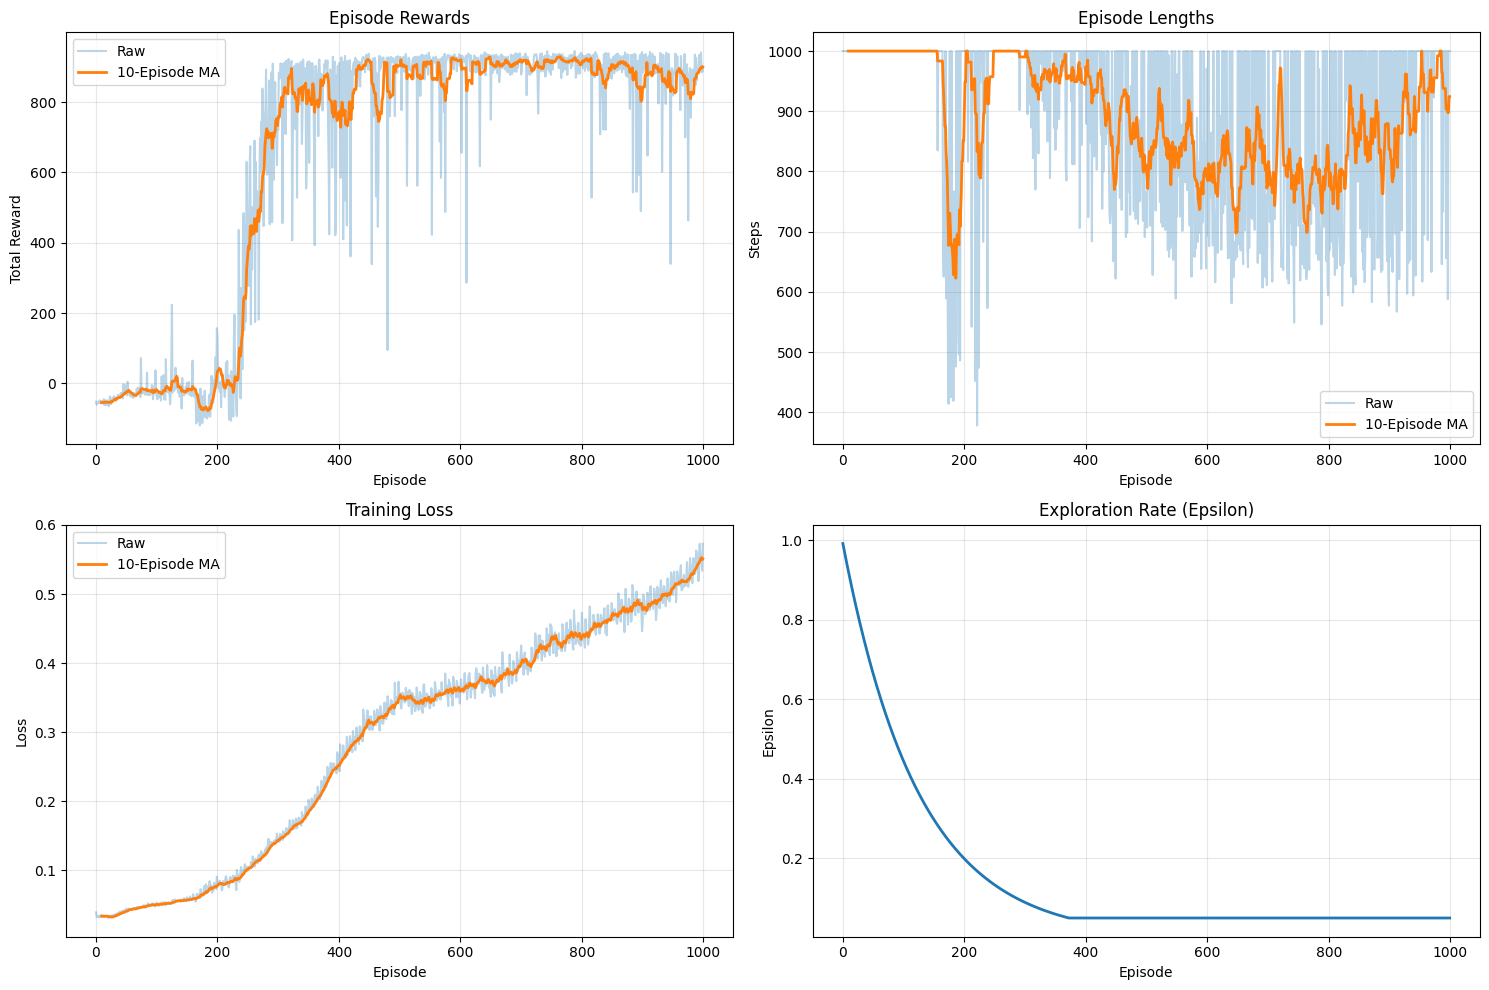

In [15]:
def plot_training_results(stats, window=10):
    """Plot training curves"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Episode Rewards
    axes[0, 0].plot(stats['episode_rewards'], alpha=0.3, label='Raw')
    if len(stats['episode_rewards']) >= window:
        moving_avg = np.convolve(stats['episode_rewards'], 
                                np.ones(window)/window, mode='valid')
        axes[0, 0].plot(range(window-1, len(stats['episode_rewards'])), 
                       moving_avg, linewidth=2, label=f'{window}-Episode MA')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Total Reward')
    axes[0, 0].set_title('Episode Rewards')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Episode Lengths
    axes[0, 1].plot(stats['episode_lengths'], alpha=0.3, label='Raw')
    if len(stats['episode_lengths']) >= window:
        moving_avg = np.convolve(stats['episode_lengths'], 
                                np.ones(window)/window, mode='valid')
        axes[0, 1].plot(range(window-1, len(stats['episode_lengths'])), 
                       moving_avg, linewidth=2, label=f'{window}-Episode MA')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Steps')
    axes[0, 1].set_title('Episode Lengths')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Training Loss
    if stats['losses']:
        axes[1, 0].plot(stats['losses'], alpha=0.3, label='Raw')
        if len(stats['losses']) >= window:
            moving_avg = np.convolve(stats['losses'], 
                                    np.ones(window)/window, mode='valid')
            axes[1, 0].plot(range(window-1, len(stats['losses'])), 
                           moving_avg, linewidth=2, label=f'{window}-Episode MA')
        axes[1, 0].set_xlabel('Episode')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].set_title('Training Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Epsilon Decay
    axes[1, 1].plot(stats['epsilons'], linewidth=2)
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Epsilon')
    axes[1, 1].set_title('Exploration Rate (Epsilon)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot results
plot_training_results(training_stats)

## 12. Evaluation and Testing

In [16]:
def evaluate_agent(agent, env, num_episodes=10, render=False):
    """Evaluate trained agent"""
    episode_rewards = []
    episode_lengths = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        frame_stack = FrameStack(num_stack=4)
        
        processed_frame = preprocess_frame(state)
        for _ in range(4):
            frame_stack.add_frame(processed_frame)
        current_state = frame_stack.get_state()
        
        episode_reward = 0
        steps = 0
        
        while True:
            action_idx = agent.select_action(current_state, training=False)
            action = ACTIONS[action_idx]
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            processed_frame = preprocess_frame(next_state)
            frame_stack.add_frame(processed_frame)
            current_state = frame_stack.get_state()
            
            episode_reward += reward
            steps += 1
            
            if done:
                break
        
        episode_rewards.append(episode_reward)
        episode_lengths.append(steps)
        print(f"Episode {episode+1}: Reward = {episode_reward:.2f}, Length = {steps}")
    
    print(f"\n=== Evaluation Results ===")
    print(f"Average Reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
    print(f"Average Length: {np.mean(episode_lengths):.2f} ± {np.std(episode_lengths):.2f}")
    print(f"Best Reward: {np.max(episode_rewards):.2f}")
    print(f"Worst Reward: {np.min(episode_rewards):.2f}")
    
    return episode_rewards, episode_lengths

# Load best model and evaluate
agent.load('models/best_model.pth')
eval_rewards, eval_lengths = evaluate_agent(agent, env, num_episodes=10)

env.close()

/tmp/ipykernel_125/1000689568.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=device)


Episode 1: Reward = 937.80, Length = 622
Episode 2: Reward = 935.80, Length = 642
Episode 3: Reward = 936.90, Length = 631
Episode 4: Reward = 934.60, Length = 654
Episode 5: Reward = 936.10, Length = 639
Episode 6: Reward = 936.60, Length = 634
Episode 7: Reward = 890.80, Length = 1000
Episode 8: Reward = 896.86, Length = 1000
Episode 9: Reward = 939.90, Length = 601
Episode 10: Reward = 873.68, Length = 1000

=== Evaluation Results ===
Average Reward: 921.90 ± 23.44
Average Length: 742.30 ± 169.21
Best Reward: 939.90
Worst Reward: 873.68


## 13. Performance Analysis

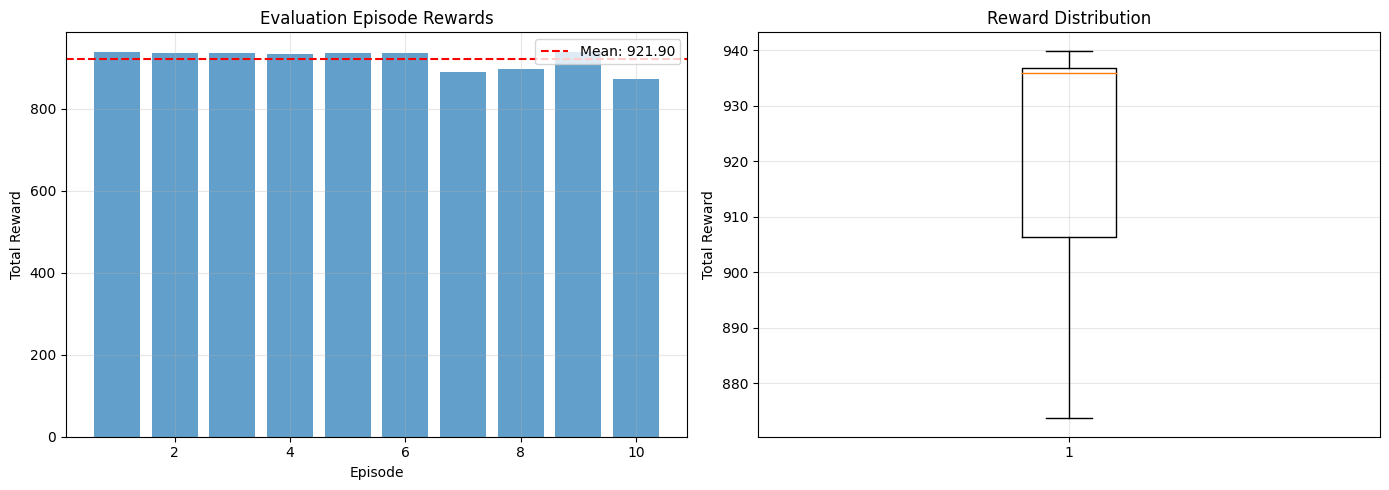

In [17]:
def plot_evaluation_results(eval_rewards):
    """Plot evaluation results"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar plot of episode rewards
    axes[0].bar(range(1, len(eval_rewards)+1), eval_rewards, alpha=0.7)
    axes[0].axhline(y=np.mean(eval_rewards), color='r', linestyle='--', 
                   label=f'Mean: {np.mean(eval_rewards):.2f}')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Total Reward')
    axes[0].set_title('Evaluation Episode Rewards')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Box plot
    axes[1].boxplot(eval_rewards, vert=True)
    axes[1].set_ylabel('Total Reward')
    axes[1].set_title('Reward Distribution')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_evaluation_results(eval_rewards)

## 14. Fine Tuning

We tried different hyperparameter combinations to improve performance.

In [20]:
# Define hyperparameter search space
HYPERPARAMETER_CONFIGS = [


    {
        'name': 'Higher LR',
        'learning_rate': 3e-4,           # plus haut mais pas trop (stabilité)
        'gamma': 0.99,
        'epsilon_decay': 0.995,
        'batch_size': 64,
        'buffer_size': 200_000,          # même buffer pour comparabilité
        'target_update': 5000,
        'epsilon_start': 1.0,
        'epsilon_end': 0.05,
        'num_episodes': 1000,
        'max_steps': 1000,
    },

    {
        'name': 'Larger Buffer',
        'learning_rate': 1e-4,
        'gamma': 0.99,
        'epsilon_decay': 0.995,
        'batch_size': 64,                # cohérent avec baseline
        'buffer_size': 500_000,          # 2.5x plus grand
        'target_update': 5000,
        'epsilon_start': 1.0,
        'epsilon_end': 0.05,
        'num_episodes': 1000,
        'max_steps': 1000,
    },
]

print("Hyperparameter configurations for tuning:")
for i, config in enumerate(HYPERPARAMETER_CONFIGS):
    print(f"\nConfig {i+1}: {config['name']}")
    for key, value in config.items():
        if key != 'name':
            print(f"  {key:20s}: {value}")

Hyperparameter configurations for tuning:

Config 1: Higher LR
  learning_rate       : 0.0003
  gamma               : 0.99
  epsilon_decay       : 0.995
  batch_size          : 64
  buffer_size         : 200000
  target_update       : 5000
  epsilon_start       : 1.0
  epsilon_end         : 0.05
  num_episodes        : 1000
  max_steps           : 1000

Config 2: Larger Buffer
  learning_rate       : 0.0001
  gamma               : 0.99
  epsilon_decay       : 0.995
  batch_size          : 64
  buffer_size         : 500000
  target_update       : 5000
  epsilon_start       : 1.0
  epsilon_end         : 0.05
  num_episodes        : 1000
  max_steps           : 1000


In [ ]:
tuning_results = {}

for config in HYPERPARAMETER_CONFIGS:
    print(f"\n{'='*60}")
    print(f"Training with config: {config['name']}")
    print(f"{'='*60}")
    
    env = gym.make('CarRacing-v2', render_mode='rgb_array')
    agent = DQNAgent(NUM_ACTIONS, config)
    
    save_dir = f"models/{config['name'].replace(' ', '_').lower()}"
    stats = train_dqn(agent, env, config, save_dir=save_dir)
    
    tuning_results[config['name']] = stats
    env.close()

# Compare results
plt.figure(figsize=(12, 6))
for name, stats in tuning_results.items():
    window = 10
    moving_avg = np.convolve(stats['episode_rewards'], 
                             np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(stats['episode_rewards'])), 
             moving_avg, linewidth=2, label=name)

plt.xlabel('Episode')
plt.ylabel('Average Reward (10-episode MA)')
plt.title('Hyperparameter Tuning Results')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('hyperparameter_tuning.png', dpi=300, bbox_inches='tight')
plt.show()

print("Hyperparameter tuning code ready (active)")
print("Running experiments with different configurations...")



Training with config: Higher LR


Training:   0%|          | 3/1000 [01:13<6:46:19, 24.45s/it]


KeyboardInterrupt: 

## 15. Video and Gif

In [23]:
!pip install imageio imageio-ffmpeg

In [ ]:
import gymnasium as gym
import numpy as np
import imageio
import cv2
from pathlib import Path

def record_episode(
    agent,
    mp4_path="agent_run.mp4",
    num_steps=500,
    fps=30,
    to_gif=False,
    gif_path="agent_run.gif",
    gif_fps=30,
    resize=None
):
    """
    Joue un épisode avec l'agent et enregistre une vidéo +  un GIF.
    """
    mp4_path = Path(mp4_path)
    gif_path = Path(gif_path) if to_gif else None

    env = gym.make("CarRacing-v2", render_mode="rgb_array")
    state, _ = env.reset()

    frame_stack = FrameStack(num_stack=4)
    processed = preprocess_frame(state)
    for _ in range(4):
        frame_stack.add_frame(processed)
    current_state = frame_stack.get_state()

    episode_reward = 0.0
    frames_for_gif = []

    writer = imageio.get_writer(
        mp4_path.as_posix(),
        fps=fps,
        codec="libx264",
        format="FFMPEG",
        output_params=["-pix_fmt", "yuv420p"]
    )

    try:
        for step in range(num_steps):
            action_idx = agent.select_action(current_state, training=False)
            action = ACTIONS[action_idx]

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward

            frame_rgb = next_state 
            if resize is not None:
                frame_rgb = cv2.resize(frame_rgb, resize, interpolation=cv2.INTER_AREA)
            frame_rgb = np.asarray(frame_rgb, dtype=np.uint8)

            writer.append_data(frame_rgb)
            if to_gif:
                frames_for_gif.append(frame_rgb)

            processed = preprocess_frame(next_state)
            frame_stack.add_frame(processed)
            current_state = frame_stack.get_state()

            if done:
                break
    finally:
        writer.close()
        env.close()

    print(f"Vidéo enregistrée : {mp4_path} | Reward total : {episode_reward:.2f}")

    if to_gif and len(frames_for_gif) > 0:
        imageio.mimsave(gif_path.as_posix(), frames_for_gif, duration=1.0/gif_fps, loop=0)
        print(f"GIF enregistré : {gif_path}")

agent.load('models/best_model.pth')
record_episode(agent, mp4_path="run_car_racing.mp4", num_steps=2000, fps=30, to_gif=True, gif_path="run_car_racing.gif", gif_fps=20, resize=(512, 512))


/tmp/ipykernel_125/1000689568.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=device)
Multiple -pix_fmt options specified

Vidéo enregistrée : run_car_racing.mp4 | Reward total : 933.10
GIF enregistré : run_car_racing.gif
